# <center> Практика. Статистические тесты в контексте EDA

## Постановка задачи

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

В процессе своего анализа вы должны:

- Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.
- А также ответить на ключевые вопросы HR-агентства:
- Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
- Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
- Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
- Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?
- Если вы найдёте в данных интересные закономерности, также отметьте их в своём анализе.

Продемонстрируйте использование разных тестов для проверки статистической значимости сделанных выводов:

1) тесты для количественного признака:
- для одной выборки;
- для двух выборок;
- для нескольких выборок;
2) тест для категориальных признаков.

Данные содержат следующие столбцы:
* work_year	Год, в котором была выплачена зарплата.
* experience_level	Опыт работы на этой должности в течение года со следующими возможными значениями:
    * EN — Entry-level/Junior;
    * MI — Mid-level/Intermediate;
    * SE — Senior-level/Expert;
    * EX — Executive-level/Director.
* employment_type	Тип трудоустройства для этой роли:
    * PT — неполный рабочий день;
    * FT — полный рабочий день;
    * CT — контракт;
    * FL — фриланс.
* job_title	Роль, в которой соискатель работал в течение года.
* salary	Общая выплаченная валовая сумма заработной платы.
* salary_currency	Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217.
* salary_in_usd	Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com).
* employee_residence	Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166.
* remote_ratio	Общий объём работы, выполняемой удалённо. Возможные значения:
    * 0 — удалённой работы нет (менее 20 %);
    * 50 — частично удалённая работа;
    * 100 — полностью удалённая работа (более 80 %).
* company_location	Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.
* company_size	Среднее количество людей, работавших в компании в течение года:
    * S — менее 50 сотрудников (небольшая компания);
    * M — от 50 до 250 сотрудников (средняя компания);
    * L — более 250 сотрудников (крупная компания).

## Загрузка данных

In [18]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns
ds=pd.read_csv("C:\SkillFactory\учебный материал\data\ds_salaries.csv")


<>:11: SyntaxWarning: invalid escape sequence '\S'
<>:11: SyntaxWarning: invalid escape sequence '\S'
C:\Users\govor\AppData\Local\Temp\ipykernel_5596\3952955740.py:11: SyntaxWarning: invalid escape sequence '\S'
  ds=pd.read_csv("C:\SkillFactory\учебный материал\data\ds_salaries.csv")


## Описательный анализ данных

In [19]:
# Проверяем на наличие пропусков
display(ds.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


None

Проверим данные на наличие полных дубликатов:

In [20]:
# создаем список с названием колонок
dubl_colums=list(ds.columns)
dubl_colums.remove('Unnamed: 0')
# удаляем дубликаты указав в функцию drop_duplicates параметр subset и передали в него список с именами колонок
ds=ds.drop_duplicates(subset=dubl_colums)
ds=ds.drop('Unnamed: 0',axis=1)


Обнаружили и удалили 42 дубликата

In [21]:
# создаем пустой список неинформативных колонок
low_information_cools=[]
for cool in ds.columns:
    # наибольшая относительная частота в признаке
    top_freq=ds[cool].value_counts(normalize=True).max()
    # доля уникальных значений
    nuniqe_ratio=ds[cool].nunique()/ds[cool].count()
    # сравниваем наибольшую частоту с порогом
    if top_freq>0.95:
        low_information_cools.append(cool)
        print(f'{cool}:{round(top_freq*100,2)} одинаковых значений')
    # сравниваем долю уникальных значений с порогом
    if nuniqe_ratio>0.95:
        low_information_cools.append(cool)
        print(f'{cool}:{round(nuniqe_ratio*100,2)} уникальных значений')
# удаляем неинформативный признак
ds=ds.drop(low_information_cools,axis=1)

employment_type:96.64 одинаковых значений


Надйем категориальные признаки

In [22]:
# создаем пустой список 
unique_list=[]
# проходимся циклом по признакам
for col in ds.columns:
    # создаем картедж название признака, число уникальных значений, тип
    item=(col, ds[col].nunique(),ds[col].dtypes)
    # добавляем кортедж в список
    unique_list.append(item)
# создаем вспомогательную таблицу и сортируем ее
unique_counts=pd.DataFrame(
    unique_list,
    columns=['Column_name','Num_Unique','Type']
).sort_values(by='Num_Unique', ignore_index=True)
display(unique_counts)
display(ds.info())

,Column_name,Num_Unique,Type
0,work_year,3,int64
1,remote_ratio,3,int64
2,company_size,3,object
3,experience_level,4,object
4,salary_currency,17,object
5,job_title,50,object
6,company_location,50,object
7,employee_residence,57,object
8,salary,272,int64
9,salary_in_usd,369,int64


<class 'pandas.core.frame.DataFrame'>
Index: 565 entries, 0 to 606
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           565 non-null    int64 
 1   experience_level    565 non-null    object
 2   job_title           565 non-null    object
 3   salary              565 non-null    int64 
 4   salary_currency     565 non-null    object
 5   salary_in_usd       565 non-null    int64 
 6   employee_residence  565 non-null    object
 7   remote_ratio        565 non-null    int64 
 8   company_location    565 non-null    object
 9   company_size        565 non-null    object
dtypes: int64(4), object(6)
memory usage: 48.6+ KB


None

In [23]:
# преоразуем категориальные признаки исходя из таблицы
# задем максимально число уникальных категорий
max_unique_count=270
for col in ds.columns:
    if ds[col].nunique()<max_unique_count and col!='work_year':
        ds[col]=ds[col].astype('category')
display(ds.info())

<class 'pandas.core.frame.DataFrame'>
Index: 565 entries, 0 to 606
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   work_year           565 non-null    int64   
 1   experience_level    565 non-null    category
 2   job_title           565 non-null    category
 3   salary              565 non-null    int64   
 4   salary_currency     565 non-null    category
 5   salary_in_usd       565 non-null    int64   
 6   employee_residence  565 non-null    category
 7   remote_ratio        565 non-null    category
 8   company_location    565 non-null    category
 9   company_size        565 non-null    category
dtypes: category(7), int64(3)
memory usage: 30.0 KB


None

In [24]:
# основные статистические характеристики 
ds.describe().loc[:,['salary','salary_in_usd']]

,salary,salary_in_usd
count,5.650000e+02,565.000000
mean,3.381160e+05,110610.343363
std,1.599879e+06,72280.702792
min,4.000000e+03,2859.000000
25%,6.700000e+04,60757.000000
50%,1.109250e+05,100000.000000
75%,1.650000e+05,150000.000000
max,3.040000e+07,600000.000000


### Распределение зарплат

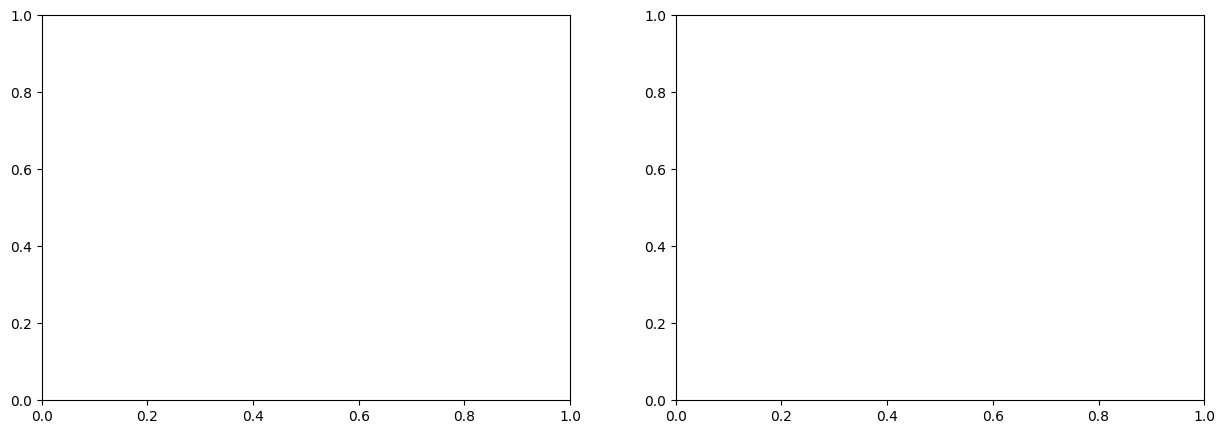

In [25]:
fig, axex = plt.subplots(1,2, figsize=(15,5))
